# TODO 

Create issue ->Title: add comments to analysis 

# Imports

In [1]:
# Pandas is an open source data analysis and manipulation tool
import pandas as pd

# library to create visualizations
import seaborn as sns

# library to create visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as md

#from statsmodels.tsa.stattools import adfuller

import itertools



# Load Dataframe

In [6]:
#read dataframe
Occurence_df = pd.read_csv("/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/DataFrames/Combined_Dataframe_02032022.csv") 
#set correact_datatypes for dataframe
Occurence_df = set_correct_datatypes(Occurence_df)


In [7]:
Occurence_df

,KeyWord,date,Occurence_in_News,normalized_Occurence_in_News,Occurence_in_Google,Occurence_in_Google_normalized,Occurence_in_Wikipedia,normalized_Occurence_in_Wikipedia
0,Ist,2021-11-07,1,0.25,88,0.88,14,0.076923
1,Ist,2021-11-08,0,0.00,90,0.90,33,0.181319
2,Ist,2021-11-09,0,0.00,93,0.93,23,0.126374
3,Ist,2021-11-10,0,0.00,96,0.96,35,0.192308
4,Ist,2021-11-11,1,0.25,93,0.93,26,0.142857
...,...,...,...,...,...,...,...,...
52404,Handel,2022-02-24,0,0.00,84,0.84,122,0.305764
52405,Handel,2022-02-25,0,0.00,72,0.72,97,0.243108
52406,Handel,2022-02-26,0,0.00,58,0.58,81,0.203008
52407,Handel,2022-02-27,0,0.00,64,0.64,105,0.263158


# Set correct datatypes

In [3]:
def set_correct_datatypes(dataframe):
    dataframe.KeyWord.astype(str)
    dataframe["date"] = pd.to_datetime(dataframe["date"], format='%Y-%m-%d')
    return dataframe


# Helper

In [4]:
#save dataframe as csv 
def saveCSV(dataframe, filename):
    dataframe.to_csv("/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/DataFrames/"+ filename +".csv",index=False)


# Visuals

In [5]:
# standard function to plot a linegraph
def plot_Occurence_over_time_linegraph(i_dataframe_o, KeyWord, Occurence_Columns, figsize):
    #copy inputs
    dataframe = i_dataframe_o.copy()
    #copy columns that will get plotted
    Occurence_Columns_copy = Occurence_Columns.copy()
    # get all rows by keyword
    dataframe = dataframe.loc[(dataframe["KeyWord"] == KeyWord)]
    #extend column that will get plotted 
    Occurence_Columns.extend(["date","KeyWord"])
    #slice dataframe
    dataframe = dataframe[Occurence_Columns]
    #set index
    dataframe = dataframe.set_index("date")
    
    #set size of the plot
    fig, ax = plt.subplots(figsize = (15, 7))
    #create plot
    sns.lineplot(ax = ax, data=dataframe).set_title('Occurence over time: ' + KeyWord)
    #set label
    plt.xlabel('Date')
    plt.ylabel('Occurence')
    
    #calculate the correlation between each "occurence_column"
    column_1 = dataframe["normalized_Occurence_in_News"]
    for Occurence_Column in Occurence_Columns_copy:
        column_2 = dataframe[Occurence_Column]
        correlation = column_1.corr(column_2)
        print("Correlation between news and "+ Occurence_Column +" is: "+ str(correlation))
                
    return dataframe

#deprecated
def plot_Occurece_over_time_heatmap(i_dataframe_o,KeyWord,Occurence_Columns):
    # copy inputs
    dataframe = i_dataframe_o.copy()
    Occurence_Columns_copy = Occurence_Columns.copy()
    # get all rows by keyword
    dataframe = dataframe.loc[(dataframe["KeyWord"] == KeyWord)]
    Occurence_Columns.extend(["date","KeyWord"])
    dataframe = dataframe[Occurence_Columns]
    #dataframe = dataframe.set_index("date")
    
    return dataframe
    #sns.heatmap(dataframe, robust=True, cmap='YlGnBu', yticklabels=False, xticklabels=5, cbar=False)



#deprecated
def check_granger_causality(i_dataframe_o, KeyWord, Columns):
    dataframe = i_dataframe_o.loc[(i_dataframe_o["KeyWord"] == KeyWord)]

    # check for stationary
    for Column in Columns:        
        result = adfuller(dataframe[Column])
        print(f'Column: ' + Column)
        print(f'Test Statistics: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'critical_values: {result[4]}')
        
        if result[1] > 0.05:
            print("Series is not stationary")
            df_transformed = dataframe.diff()
            
        else:
            print("Series is stationary")
        print()

## Plot a single word

Correlation between news and normalized_Occurence_in_News is: 1.0
Correlation between news and Occurence_in_Google_normalized is: 0.9017895815130134
Correlation between news and normalized_Occurence_in_Wikipedia is: 0.9457086624397183


,normalized_Occurence_in_News,Occurence_in_Google_normalized,normalized_Occurence_in_Wikipedia
count,114.000000,114.000000,114.000000
mean,0.041508,0.038947,0.046235
std,0.120580,0.140469,0.131566
min,0.000000,0.000000,0.003216
25%,0.000000,0.000000,0.005429
50%,0.007246,0.000000,0.008165
75%,0.028986,0.020000,0.020928
max,1.000000,1.000000,1.000000


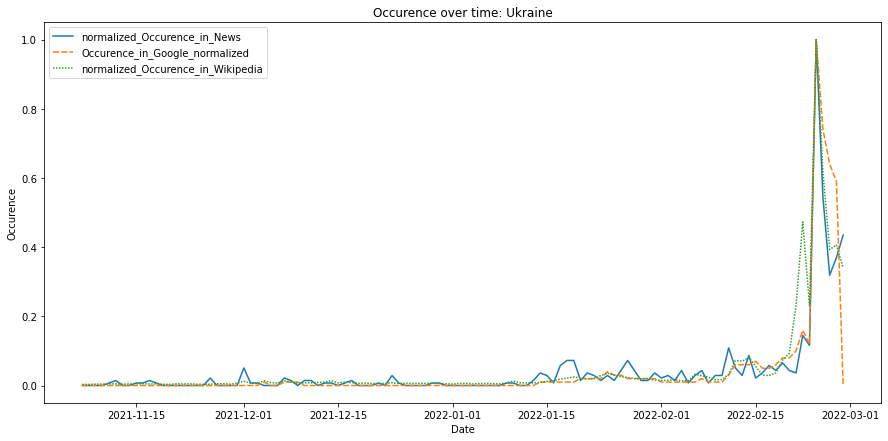

In [70]:


normalized_data = ["normalized_Occurence_in_News","Occurence_in_Google_normalized","normalized_Occurence_in_Wikipedia"]
x = plot_Occurence_over_time_linegraph(Occurence_df,"Ukraine", normalized_data,(20,8))
x.describe()

# Create correlation dataframe

In [10]:
#list of normalized occurence columns
normalized_data = ["normalized_Occurence_in_News","Occurence_in_Google_normalized","normalized_Occurence_in_Wikipedia"]

#function to calculate the correlation between normalized occurence columns
def calculate_correlation(dataframe):  
    # decimals to round the correlation to
    decimals = 2
    # get normalized occurence of news
    News = dataframe["normalized_Occurence_in_News"]
    # get normalized occurence of google
    Google = dataframe["Occurence_in_Google_normalized"]
    # get normalized occurence of wikipedia
    Wikipedia = dataframe["normalized_Occurence_in_Wikipedia"]
    # calculate correlation manually
    dataframe["correlation_news_google"] = round(News.corr(Google) , decimals)
    dataframe["correlation_news_wikipedia"] = round(News.corr(Wikipedia), decimals)
    dataframe["correlation_google_wikipedia"] = round(Google.corr(Wikipedia), decimals)   
    return dataframe

#group the dataframe by keywords and apply the correlation calculation
Correlation_DataFrame = Occurence_df.groupby("KeyWord").apply(calculate_correlation)
#sort values by correlation columns
Correlation_DataFrame = Correlation_DataFrame.sort_values("correlation_news_google", ascending=False)

#drop duplicates by KeyWord for "short version" of dataframe
Correlation_DataFrame_short= Correlation_DataFrame.drop_duplicates(subset="KeyWord")
#shorten the dataframe further by exluding columns
Correlation_DataFrame_short = Correlation_DataFrame_short[["KeyWord","correlation_news_google", "correlation_news_wikipedia", "correlation_google_wikipedia"]]

#saveCSV(Correlation_DataFrame, "Correlation_DataFrame_short")

    

/Users/jan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/jan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [116]:
#function to calculate the rolling standard deviation
def calculate_rolling_standard_deviation(df):
    #window size = ammount of dates in frame
    window_size = 4
    
    #calculate std = "standard deviation" over the rolling windows 
    data = df['Occurence_in_News'].rolling(window_size).std()
    #data = data[window_size - 1 :: window_size]
    #print(data)
    #create new column and set data 
    df["Window_standard_deviation"] = data
    return df

    

KeyWord
Bei                  0.577350
Kalenderblatt        0.577350
Sturz                0.577350
Premier              0.577350
Halle                0.577350
Coronavirus          0.577350
Champions            0.577350
Australien           0.577350
Tatort               0.577350
Missbrauch           0.577350
Kraft                0.577350
Abend                0.577350
Impfstoff            0.577350
Stream               0.558768
Landtag              0.552355
Nord                 0.540233
St.                  0.539274
League               0.533594
Im                   0.533594
Fünf                 0.525991
Tempo                0.525991
Rückkehr             0.525991
Haus                 0.525991
Ministerium          0.525991
Wechsel              0.525991
Silvester            0.523678
Wohnhaus             0.515388
Paris                0.515388
Angeklagter          0.515388
Sandhausen           0.515388
Vertrag              0.515388
Westen               0.515388
Bürgermeister        0.515388
De

<AxesSubplot:xlabel='date', ylabel='Standard Deviation'>

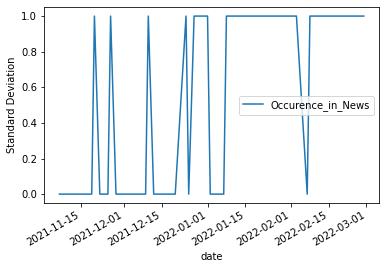

In [115]:
# calculate rolling standard deviation over groupby(keyWord)
std_DataFrame = Occurence_df.groupby("KeyWord").apply(calculate_rolling_standard_deviation)
#get a list of highest or lowest standard deviation
std_DataFrame_sorted = std_DataFrame.groupby("KeyWord")["Window_standard_deviation"].max().sort_values(ascending=False)
#print list
print(std_DataFrame_sorted[:40])
#plot standard deviation
std_DataFrame.loc[std_DataFrame['KeyWord'] == "Kalenderblatt"].plot(x="date",y="Occurence_in_News", ylabel="Standard Deviation")


#Column_list= ["Window_standard_deviation", "Occurence_in_News"]
#x = plot_Occurence_over_time_linegraph(std_DataFrame,"Putin", Column_list,(20,8))


KeyWord
Familie     -0.23
Köln        -0.25
Inzidenz    -0.27
Thüringen   -0.30
Preise        NaN
Name: correlation_news_wikipedia, dtype: float64


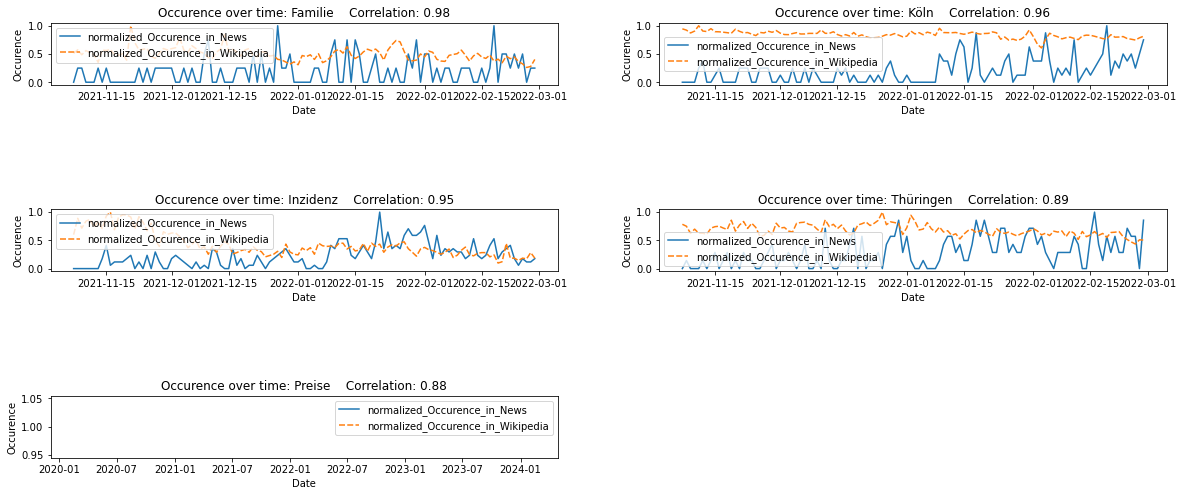

In [100]:
# plot top 5 keywords with normalized occurence
plot_time_series_basedOn_correlation(Correlation_DataFrame,"correlation_news_wikipedia", 
                                   ["normalized_Occurence_in_News","normalized_Occurence_in_Wikipedia"],5)


In [99]:
#function to plot timeseries based on correlation
def plot_time_series_basedOn_correlation(i_dataframe_o, correlation_column, columns_to_plot, N_keyWords):
    #get list of KeyWords sorted by keywords
    keyWord_list = i_dataframe_o.groupby("KeyWord")[correlation_column].max().sort_values(ascending=False)
    #get top N keywords
    top_5_keywords = keyWord_list[:N_keyWords].index.tolist()
    #get bottom N keywords
    bottom_5_keywords =keyWord_list[-N_keyWords:].index.tolist()
    #extend list 
    columns_to_plot.extend(["date","KeyWord"])
    #define chart size
    plt.figure(figsize=(20, 8))
    #define space between charts
    plt.subplots_adjust(hspace=2)
    print(keyWord_list[-N_keyWords:])
    #plot keywords    
    for n, keyWord in enumerate(bottom_5_keywords):
        #copy the dataframe
        dataframe = i_dataframe_o.copy()
        # get all rows by keyword
        dataframe = dataframe.loc[(dataframe["KeyWord"] == keyWord)]
        #get columns of interest 
        dataframe = dataframe[columns_to_plot]
        #set index
        dataframe = dataframe.set_index("date")
                
        # add a new subplot iteratively
        ax = plt.subplot(3, 2, n + 1)
        #ax.text(0.85, 0.85,"Correlation:", fontsize=9) #add text

        # plot chart
        plot = sns.lineplot(ax = ax, data=dataframe).set_title('Occurence over time: ' + keyWord + f"    Correlation: {keyWord_list[n]}")
        plot = plot.get_figure()
        #plot.savefig(f"/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/Plots/{n}_top_keyword_timeseries")
        
        
        #set labels
        plt.xlabel('Date')
        plt.ylabel('Occurence')
        
    #plot.savefig("/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/Plots/bottom_5_timeSeries_based_on_correlation.png")
        
    

In [37]:
top_5_keywords

NameError: name 'top_5_keywords' is not defined

In [12]:
plot.savefig("/Users/jan/Documents/Python_Projects/Bachelorthesis/Analysis/Plots/Top_5_timeSeries_based_on_correlation.png")

NameError: name 'plot' is not defined